# Spacia Example Workflow

In this notebook, we are going to walk through an example workflow of comparing spatial interaction of sending signals from Fibroblasts and Endothelial cells to Epithelial-to-Mesenchymal Transition (EMT) process in the prostate cancer cells, as described in the Figure 3d of the [manuscript](https://doi.org/10.1038/s41592-024-02408-1).

## Steps

1. Install Spacia and its dependencies following the steps in the Readme page on Github
2. Spacia Job Generation for parallel run
3. Parsing and combining results
4. Spatial signature calculation
5. Kernel Density Estimation and correlation analysis

## Prerequisites for running your own discovery experiments using Spacia

1. The data is single-cell resolution spatial dataset, such as MERSCOPE, CosMx, or Xenium.
2. Cell annotation needs to be done on the spatial dataset








In [1]:
# Libraries
import os
import sys
from pathlib import Path
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Spacia Job Generation for Parallel Runs

The following function and example generates SLURM job scripts for running Spacia on a high-performance computing cluster. It's specifically tailored for the UT Southwestern HPC environment so may require adjustments for different setups. The script creates multiple job scripts, each processing a subset of receiving genes for a specific pair of sending and receiving cell types. It also generates a master script to submit all jobs at once.

## Key Components

1. **Input Validation**: 
   - Checks if specified cell types exist in the metadata.
   - Verifies if all genes are present in the expression data.

2. **Job Script Generation**:
   - Creates individual job scripts, each handling multiple receiving genes.
   - Includes SLURM directives and necessary module loading commands.

3. **Master Script Creation**:
   - Generates a script to submit all individual job scripts.

4. **File Organization**:
   - Organizes output and job scripts in specified directories.

## Important Notes

- **HPC Environment**: This script is designed for a specific RedHat HPC cloud environment. You may need to adjust paths, module loading commands, and SLURM directives for your specific cluster setup.

- **Cell Type Pairs**: The current implementation processes receiving genes for a single pair of sending and receiving cell types. To analyze multiple cell type pairs, you would need to wrap this script in another loop or function that iterates over different cell type combinations.

- **Customization**: 
  - Adjust the `max_jobs_per_script` variable to control how many genes are processed in each job script.
  - Modify file paths and parameters at the bottom of the script to match your specific data and directory structure.

- **Receiving Gene Cutoff**: Updates to the Spacia R allows for finding the cutoff for receiving gene's expression automatically, which is crucial for Spacia to run accurately. We employ a gene signature approach for best handling the receiving gene's expression. A single gene is expanded into a signature by incorporating the expression of other genes that are correlated with the single receiving gene in terms of expression. The correlation coefficients serve as the weights for the weighted average.

## Usage

1. Set the appropriate variables (cell types, gene lists, file paths).
2. Run the generate_spacia_jobs function to generate job scripts and the master script.
3. Execute the master script to submit all jobs to the SLURM scheduler.

## Potential Modifications

- For processing multiple cell type pairs, consider creating a wrapper function that calls `generate_spacia_jobs` with different cell type combinations.
- Adjust the SLURM directives in the job script header if you need different resource allocations or queue specifications.
- Modify the R script command if your Spacia script accepts different parameters or requires additional options.

Remember to test the generated scripts with a small subset of data before running large-scale analyses to ensure everything works as expected in your specific HPC environment.

In [2]:
def generate_spacia_jobs(
    receiving_cell: str,
    sending_cell: str,
    receiving_genes: List[str],
    metadata_file: str,
    expression_file: str,
    output_dir: str,
    spacia_script: str,
    spacia_core_dir: str,
    job_dir: str,
    max_jobs_per_script: int = 1
) -> None:
    """
    Generate SLURM job scripts for running Spacia analysis.

    Parameters:
    receiving_cell (str): Identifier for the receiving cell type
    sending_cell (str): Identifier for the sending cell type
    receiving_genes (List[str]): List of receiving genes to analyze
    metadata_file (str): Path to the metadata file
    expression_file (str): Path to the expression data file
    output_dir (str): Directory to store output files
    spacia_script (str): Path to the Spacia R script
    spacia_core_dir (str): Directory containing Spacia core files
    job_dir (str): Directory to store job scripts
    max_jobs_per_script (int): Maximum number of jobs per script (default: 1)

    Raises:
    ValueError: If cell types or genes are not found in the input data
    """

    def validate_input_data():
        metadata = pd.read_csv(metadata_file, sep="\t")
        expression = pd.read_csv(expression_file, sep="\t")

        cell_types = metadata['cell_type'].unique()
        if receiving_cell not in cell_types or sending_cell not in cell_types:
            raise ValueError(f"One or both cell types not found in metadata. Available cell types: {cell_types}")

        receiving_genes_set = set(receiving_genes)
        missing_genes = receiving_genes_set - set(expression.columns)
        if missing_genes:
            raise ValueError(f"The following genes are not found in the expression data: {missing_genes}")

    def create_directories():
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(job_dir, exist_ok=True)

    def generate_job_script_header(job_name: str, log_file: str, error_file: str) -> str:
        return f"""#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --partition=512GB,256GBv1,256GB
#SBATCH --nodes=1
#SBATCH --time=20-00:00:00
#SBATCH --output={log_file}
#SBATCH --error={error_file}
source .bashrc
module load rstudio-desktop/2022.12.0
"""

    def generate_job_command(receiving_gene: str, output_file: str) -> str:
        return f"""
Rscript {spacia_script} \\
    -x {expression_file} \\
    -m {metadata_file} \\
    -d 50 \\
    -a {spacia_core_dir} \\
    -r '{receiving_cell}' \\
    -s '{sending_cell}' \\
    -g {receiving_gene} \\
    -o {output_file} -f
"""

    def write_job_scripts():
        job_count = 0
        current_job_script = ""

        for receiving_gene in receiving_genes:
            if job_count % max_jobs_per_script == 0:
                log_file = os.path.join(job_dir, f"sbatch_{job_count // max_jobs_per_script}.log")
                error_file = os.path.join(job_dir, f"sbatch_{job_count // max_jobs_per_script}.err")
                current_job_script = generate_job_script_header(
                    f"sbatch_{sending_cell}to{receiving_cell}_{job_count // max_jobs_per_script}",
                    log_file,
                    error_file
                )

            output_file = os.path.join(output_dir, f"{sending_cell}_to_{receiving_cell}_{receiving_gene}")
            current_job_script += generate_job_command(receiving_gene, output_file)

            if (job_count + 1) % max_jobs_per_script == 0 or job_count == len(receiving_genes) - 1:
                current_job_script += f"\nchmod g+w,o+r '{log_file}'\nchmod g+w,o+r '{error_file}'\n"
                
                job_file = os.path.join(job_dir, f"sbatch_{job_count // max_jobs_per_script}.sh")
                with open(job_file, 'w') as f:
                    f.write(current_job_script)

                print(f"Created job script: {job_file}")
                current_job_script = ""

            job_count += 1

    def generate_master_script():
        master_script = f"""#!/bin/bash
# Directory containing the .sh files
script_dir="{job_dir}"
# Name of this master script
master_script="run_all_jobs.sh"
# Change to the directory
cd "$script_dir"
# Loop through all .sh files in the specified directory, excluding the master script
for script in *.sh; do
    if [ "$script" != "$master_script" ]; then
        sbatch "$script"
    fi
done
"""

        master_script_path = os.path.join(job_dir, "run_all_jobs.sh")
        with open(master_script_path, 'w') as f:
            f.write(master_script)
        
        print(f"Created master script: {master_script_path}")
        os.chmod(master_script_path, 0o755)

    # Main execution
    validate_input_data()
    create_directories()
    write_job_scripts()
    generate_master_script()

In [3]:
# Example usage
receiving_cell = "Tumor_Cells"
sending_cell = "Endothelial_Cells"
receiving_genes = ["JAK1", "AKT2", "SMO", "CTNNB1", "SMAD2", "NFKB2"]  
# Note on sending genes:
# Individual sending genes are not directly used as input to Spacia's core algorithm.
# Instead, Spacia performs PCA on the sending cells' gene expression data,
# using the top 50 principal components (by default) to capture the main patterns
# of gene expression variation. This dimensionality reduction approach allows
# Spacia to efficiently process high-dimensional gene expression data while
# retaining most of the important information. However, we can leverage the output
# from the Spacia to analyze the sending gene's signal, which will be covered later in
# the notebook.

metadata_file = "path/to/spacia_metadata.txt"
expression_file = "path/to/counts.txt"
output_dir = "path/to/Job_Out_Endo"
job_dir = "path/to/Job_Out_Endo"
spacia_script = "path/to/Spacia-main/spacia.R"
spacia_core_dir = "path/to/Spacia-main/spacia"

generate_spacia_jobs(receiving_cell, 
                     sending_cell, 
                     receiving_genes, 
                     metadata_file, 
                     expression_file, 
                     output_dir, 
                     spacia_script, 
                     spacia_core_dir, 
                     job_dir
                    )

# We need to run another set of spacia for Fibroblasts
sending_cell_1 = "Fibroblasts"
output_dir_1 = "path/to/Job_Out_Fibro"
job_dir_1 = "path/to/Job_Out_Fibro"

generate_spacia_jobs(receiving_cell, 
                     sending_cell_1, 
                     receiving_genes, 
                     metadata_file, 
                     expression_file, 
                     output_dir_1, 
                     spacia_script, 
                     spacia_core_dir, 
                     job_dir_1
                    )

# You can submit the job by running `source path/to/run_all_jobs.sh` in the command line

Created job script: path/to/Job_Out_Endo/sbatch_0.sh
Created job script: path/to/Job_Out_Endo/sbatch_1.sh
Created job script: path/to/Job_Out_Endo/sbatch_2.sh
Created job script: path/to/Job_Out_Endo/sbatch_3.sh
Created job script: path/to/Job_Out_Endo/sbatch_4.sh
Created job script: path/to/Job_Out_Endo/sbatch_5.sh
Created master script: path/to/Job_Out_Endo/run_all_jobs.sh
Created job script: path/to/Job_Out_Fibro/sbatch_0.sh
Created job script: path/to/Job_Out_Fibro/sbatch_1.sh
Created job script: path/to/Job_Out_Fibro/sbatch_2.sh
Created job script: path/to/Job_Out_Fibro/sbatch_3.sh
Created job script: path/to/Job_Out_Fibro/sbatch_4.sh
Created job script: path/to/Job_Out_Fibro/sbatch_5.sh
Created master script: path/to/Job_Out_Fibro/run_all_jobs.sh


### Import class definitions and helper functions

In [4]:
# Add spacia directory to Python path if needed
# spacia_core_dir = "/path/to/spacia_core_dir" 
if spacia_core_dir not in sys.path:
    sys.path.append(spacia_core_dir)

# Import helper functions
from Workflow_Helpers import (
    process_spacia_data,
    calculate_weighted_activation_scores,
    SpatialScore,
    create_common_grid,
    create_common_mask,
    compute_correlation
)

### Combine the results from the parallel Spacia R Runs

In [5]:
# Combine Results for each sending_cell receiving_cell pairs
combined_betas_endo, combined_pip_endo = process_spacia_data(receiving_cell, sending_cell, "path/to/Job_Out_Endo")
combined_betas_fibro, combined_pip_fibro = process_spacia_data(receiving_cell, sending_cell_1, "path/to/Job_Out_Fibro")

# Calculate Weighted Activation Scores

calculate_weighted_activation_scores() function calculates weighted activation scores for cell-cell interactions, integrating multiple data sources:

1. **Spatial Proximity**: Utilizes "bags" of neighboring cells constructed from the Spacia R run.
2. **Gene Expression**: Incorporates expression data for sender cells.
3. **Interaction Strength**: Uses beta values from Spacia to weigh the importance of gene interactions.
4. **Interaction Probability**: Employs Primary Instance Probability (PIP) scores to further refine the interaction likelihood.

The process involves several key steps:

1. **Activation Score Calculation**: For each sender cell, we calculate an activation score by multiplying its gene expression with the corresponding beta values (interaction strengths).

2. **Weighting**: These activation scores are then weighted by the PIP scores, which represent the probability of an interaction occurring between specific sender-receiver cell pairs.

3. **Aggregation**: For each receiver cell, we sum the weighted scores of all its neighboring sender cells (as defined in the proximity "bags").

The result is a compound score for each receiver cell that encapsulates:
- The expression levels of relevant genes in nearby sender cells
- The predicted strength of the gene interactions (beta values)
- The probability of these interactions occurring (PIP scores)
- The spatial context of the cells (proximity bags)

This approach provides a comprehensive measure of potential cell-cell interactions, considering both the molecular and spatial aspects of the cellular environment. It allows us to quantify the cumulative influence of neighboring cells on each receiver cell, taking into account the complex interplay of gene expression, interaction strengths, and spatial relationships.

In [6]:
# Read metadata and expression
cell_meta = pd.read_csv(metadata_file, sep = "\t")
expression_data = pd.read_csv(expression_file, sep = "\t")

In [7]:
import json

# Read the JSON file of the bags constructed from the Spacia R run
with open('path/to/Job_Out_Endo/names_sender.json', 'r') as f:
    raw_distance_dict = json.load(f)

# Convert the dictionary values to lists of cell IDs
proximity_dict_endo = {key: [item['V1'] for item in value] for key, value in raw_distance_dict.items()}

endo_score = calculate_weighted_activation_scores(
    expression_data=expression_data,
    cell_metadata=cell_meta,
    beta_values=combined_betas_endo,
    pi_scores=combined_pip_endo,
    proximity_dict=proximity_dict_endo,
    receiver_type="Tumor_Cells",
    sender_type="Endothelial_Cells",
    sending_genes=["HGF", "WNT5A", "FGF2", "IL6", "CXCL8", "FGF1", "TGFB1", "TGFB2"],
    receiving_genes=["JAK1", "AKT2", "SMO", "CTNNB1", "SMAD2", "NFKB2"],
    score_name = "Endothelial_Activation_Score"
)

endo_score

,index,X,Y,cell_type,receiving_cell,Endothelial_Activation_Score
0,cell_811,3758.670191,8800.061671,Tumor_Cells,cell_811,0.002682
1,cell_987,6839.263227,2012.945366,Tumor_Cells,cell_987,0.029871
2,cell_1087,6736.081066,2072.469613,Tumor_Cells,cell_1087,0.002497
3,cell_1155,6457.884081,2101.542582,Tumor_Cells,cell_1155,0.013157
4,cell_1175,6720.182724,2112.183529,Tumor_Cells,cell_1175,0.015869
...,...,...,...,...,...,...
4995,cell_721475,4143.218318,4026.211169,Tumor_Cells,cell_721475,0.002437
4996,cell_721492,3799.085463,4043.644716,Tumor_Cells,cell_721492,0.014383
4997,cell_721506,3976.148017,4061.203199,Tumor_Cells,cell_721506,0.030627
4998,cell_721577,4259.437335,4101.777134,Tumor_Cells,cell_721577,0.018873


In [8]:
# Read the JSON file of the bags constructed from the Spacia R run
with open('path/to/Job_Out_Fibro/names_sender.json', 'r') as f:
    raw_distance_dict_fibro = json.load(f)

# Convert the dictionary values to lists of cell IDs
proximity_dict_fibro = {key: [item['V1'] for item in value] for key, value in raw_distance_dict_fibro.items()}

fibro_score = calculate_weighted_activation_scores(
    expression_data=expression_data,
    cell_metadata=cell_meta,
    beta_values=combined_betas_fibro,
    pi_scores=combined_pip_fibro,
    proximity_dict=proximity_dict_fibro,
    receiver_type="Tumor_Cells",
    sender_type="Fibroblasts",
    sending_genes=["HGF", "WNT5A", "FGF2", "IL6", "CXCL8", "FGF1", "TGFB1", "TGFB2"],
    receiving_genes=["JAK1", "AKT2", "SMO", "CTNNB1", "SMAD2", "NFKB2"],
    score_name = "Fibroblast_Activation_Score"
)

fibro_score

,index,X,Y,cell_type,receiving_cell,Fibroblast_Activation_Score
0,cell_65,3561.062427,8529.638376,Tumor_Cells,cell_65,0.004881
1,cell_96,3798.995716,8548.548407,Tumor_Cells,cell_96,0.013227
2,cell_182,3431.954078,8684.346059,Tumor_Cells,cell_182,0.105894
3,cell_258,3702.147406,8765.232260,Tumor_Cells,cell_258,0.055354
4,cell_345,3559.454600,8822.454446,Tumor_Cells,cell_345,0.035147
...,...,...,...,...,...,...
4995,cell_720782,4014.203064,4041.095038,Tumor_Cells,cell_720782,0.018092
4996,cell_720826,3807.654148,4055.859166,Tumor_Cells,cell_720826,0.012637
4997,cell_720889,4135.741507,4084.849488,Tumor_Cells,cell_720889,0.069086
4998,cell_721247,3907.570519,3813.789808,Tumor_Cells,cell_721247,0.122357


### Calculate Tumor's EMT score based on its average expression. 

In [9]:
# Get tumor cell IDs and subset expression_data
tumor_cells = cell_meta[cell_meta['cell_type'] == 'Tumor_Cells'].index
expr_tumor = expression_data.loc[tumor_cells]

# Subset specific genes
genes_of_interest = ['FN1', 'TWIST1', 'SNAI1', 'SNAI2', 'ZEB1', 'TGFB1', 'TGFB2', 'CTNNB1']
expr_tumor_genes = expr_tumor[genes_of_interest]

# Calculate row means (average per cell) - may be substituted with AddModuleScore() in Seurat or score_genes() in scanpy
avg_gene_signature = expr_tumor_genes.mean(axis=1)

# Subsample n cells (example with n=1000)
n_cells = 5000
sampled_cells = avg_gene_signature.sample(n=n_cells)

# Subset cell_meta for tumor cells and add scores
tumor_score = cell_meta[cell_meta['cell_type'] == 'Tumor_Cells'].copy()
tumor_score['Tumor_EMT_Score'] = avg_gene_signature

tumor_score

,X,Y,cell_type,Tumor_EMT_Score
cell_4,3389.125477,8470.738361,Tumor_Cells,0.013101
cell_5,3371.862437,8469.461283,Tumor_Cells,0.014455
cell_6,3383.372307,8470.703283,Tumor_Cells,0.003208
cell_7,3527.206933,8470.840672,Tumor_Cells,0.009925
cell_8,3512.863912,8474.224527,Tumor_Cells,0.023421
...,...,...,...,...
cell_721663,3851.367159,4194.075733,Tumor_Cells,0.030703
cell_721665,4214.660918,4196.902882,Tumor_Cells,0.036458
cell_721666,4004.523448,4197.691922,Tumor_Cells,0.059464
cell_721667,3886.060066,4197.689779,Tumor_Cells,0.036458


# SpatialScore: Spatial Pattern Analysis and Correlation

`SpatialScore` provides a framework for analyzing spatial patterns of cell-cell interactions and gene signatures. Key features:

## Core Functionality
- Kernel Density Estimation (KDE) for spatial distribution analysis
- Common grid generation for comparing multiple spatial patterns
- Correlation analysis between different spatial patterns
- Visualization of the spatial plots

Here we continue to compare EMT signature in tumor cells with activation scores from nearby Fibroblasts and Endothelial cells to understand spatial correlation patterns.

In [10]:
endo_spatialscore = SpatialScore(endo_score, "Endothelial_Activation_Score")
fibro_spatialscore = SpatialScore(fibro_score, "Fibroblast_Activation_Score")
tumor_spatialscore = SpatialScore(tumor_score, "Tumor_EMT_Score")

xi, yi = create_common_grid([endo_spatialscore, fibro_spatialscore, tumor_spatialscore])
common_mask = create_common_mask([endo_spatialscore, fibro_spatialscore, tumor_spatialscore], xi, yi)

endo_spatialscore = SpatialScore(endo_score, "Endothelial_Activation_Score", xi=xi, yi=yi, mask=common_mask)
fibro_spatialscore = SpatialScore(fibro_score, "Fibroblast_Activation_Score", xi=xi, yi=yi, mask=common_mask)
tumor_spatialscore = SpatialScore(tumor_score, "Tumor_EMT_Score", xi=xi, yi=yi, mask=common_mask)

endo_spatialscore = endo_spatialscore.compute_kde()
fibro_spatialscore = fibro_spatialscore.compute_kde()
tumor_spatialscore = tumor_spatialscore.compute_kde()

<Axes: title={'center': 'Endothelial Activation Score Plot'}>

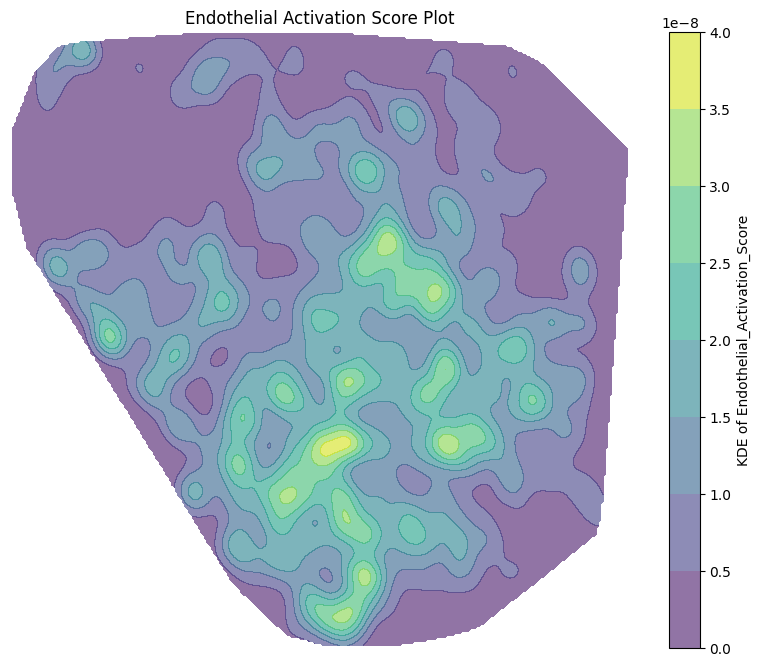

In [11]:
endo_spatialscore.plot(cmap = 'viridis', title="Endothelial Activation Score Plot")

<Axes: title={'center': 'Fibroblast Activation Score'}>

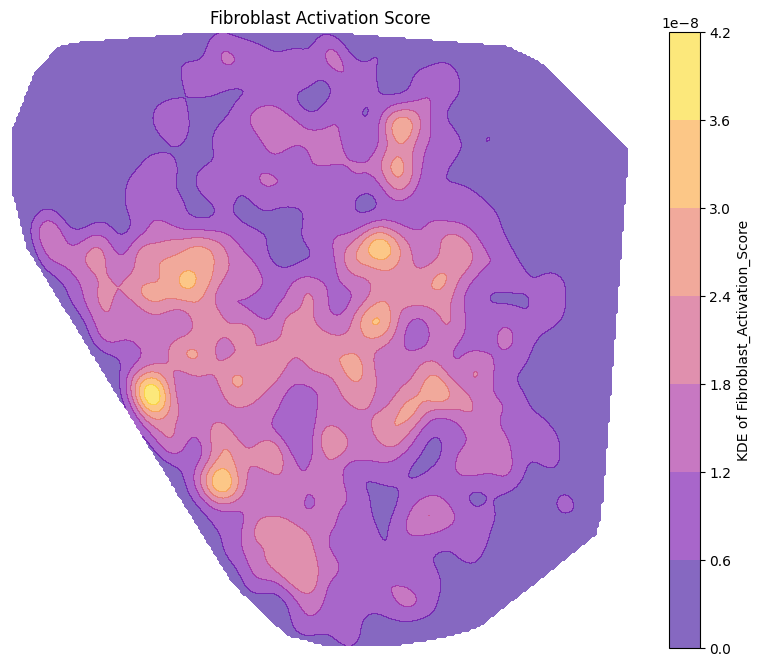

In [12]:
fibro_spatialscore.plot(cmap = 'plasma', title="Fibroblast Activation Score")

<Axes: title={'center': 'Endothelial Activation Score Plot'}>

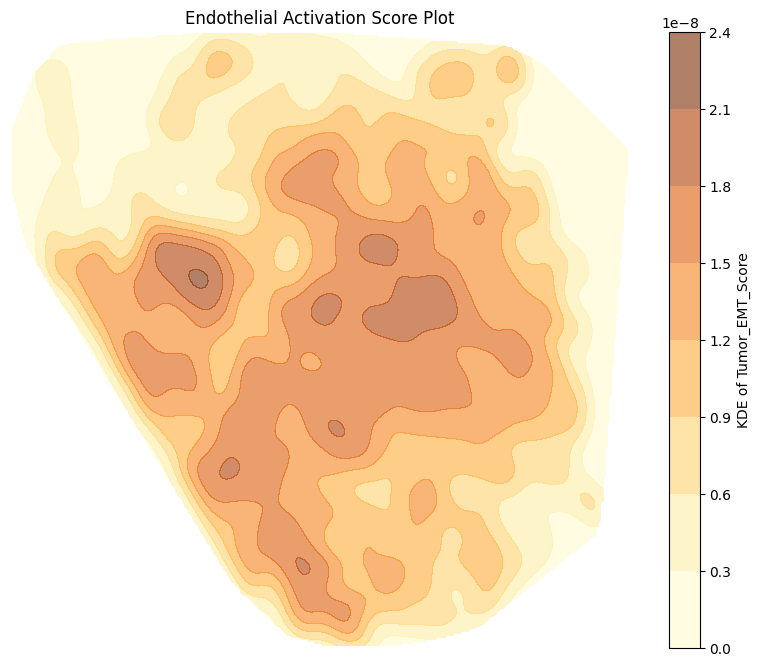

In [13]:
tumor_spatialscore.plot(cmap = 'YlOrBr', title="Endothelial Activation Score Plot")

In [14]:
corr, pval = compute_correlation(tumor_spatialscore, endo_spatialscore)
print(f"Correlation between Tumor EMT Score and Endothelial Activation Score: {corr:.4f} (p = {pval:.2e})")

Correlation between Tumor EMT Score and Endothelial Activation Score: 0.8233 (p = 0.00e+00)


In [15]:
corr, pval = compute_correlation(tumor_spatialscore, fibro_spatialscore)
print(f"Correlation between Tumor EMT Score and Fibroblast Activation Score: {corr:.4f} (p = {pval:.2e})")

Correlation between Tumor EMT Score and Fibroblast Activation Score: 0.8488 (p = 0.00e+00)
